# Real Time Eye Gaze Tracking with Kinect


In [210]:
# main tools
import cv2
import numpy as np
import pandas as pd

# utils
import os
import json
import bson
import sys
sys.path.append('../')  # for brspy
from utils import *
from pyquaternion import Quaternion
from rolling_window import rolling_window

# visualization
from tqdm import tqdm
from pprint import pprint
from PIL import Image
from matplotlib import pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
from plotly.offline import iplot

# reading brs sessions
from brspy.reader import Session

# for exporting data from BRS sessions
# from brspy.export import GazesExport
# from brspy.export import MimicsExport
# from brspy.export import JointsExport
# from brspy.export import JointOrientationsExport
# from brspy.export import FacePropertiesExport

# device utils
from devices import Camera
from devices import Device

# ML
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import *
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import Normalizer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# load autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Configuration

In [2]:
# configure plot
init_notebook_mode(connected=True)
%matplotlib inline

### markers path ###
# markers_path = r'./markers.json'  # analog markers
markers_path = r'./dots.json'  # digital markers

### dataset path ###
datasets_path = r"./datasets/07_08_18"
# datasets_path = r"D:/datasets-calibration/14_08_18"

### sessions codes ###
sessions = {
    'test': [
        '1534426982',
    ],
    'train': [
        '1533638926',  # 40 frames
        '1534255495',  # different head rotations
        '1534749770',  # "static" head rotation
    ]
}

# create session path
train_sess_path = os.path.join(datasets_path, sessions['train'][2])
test_sess_path = os.path.join(datasets_path, sessions['test'][0])

### camera parameters data
cam_data_path = r'./cam_data.json'

# load markers
with open(markers_path, 'r') as f:
    markers_db = json.load(f)

# load camera parameters
with open(cam_data_path, 'r') as f:
    cam_data = json.load(f)
    
test_markers = np.array([markers_db.get(f'screen_dot_{i+1}') for i in range(9)]) / 1000

marker_style={
    'mode': 'markers',
    'marker': dict(size=3, line=dict(color='rgba(217, 217, 217, 0.14)', width=0.5), opacity=0.8)
}

line_style={
#     'mode': 'line',
    'marker': dict(size=3, line=dict(color='rgba(217, 217, 217, 0.14)', width=0.5), opacity=0.8)
}

### Cameras 

In [3]:
for cam_name, data_dict in cam_data.items():
    Camera(cam_name, **data_dict)
    
KinectColor = Camera.get('KinectColor')
WebCamera = Camera.get('WebCamera')
InfraredCamera = Camera.get('InfraredCamera')
KinectInfrared = Camera.get('KinectInfrared')

### write markers to session

In [4]:
markers_path = r'./dots.json'
markers_save = os.path.join(train_sess_path, 'DataSource', 'cam_101')

try:
    os.mkdir(markers_save)
except:
    pass

# set snapshot counter
counter = 0

# iterate on calibration
for _ in range(360 // 9 // 10):
    
    # iterate on calibration points
    for i in range(9):
        
        # iterate on snapshot per calibration points
        for _ in range(10):
            
            # get point from dict
            marker = markers_db.get(f'screen_dot_{i+1}')
            
            if marker:
                
                # create file name
                file_name = os.path.join(markers_save, str(counter).rjust(5, '0') + '.txt')
                
                # write snapshot file
                with open(file_name, 'w') as f:
                    json.dump(to_json(marker, scale=1e-3), f)
                
                # update snapshot count
                counter += 1
            else:
                continue

## Create session

In [4]:
train_sess = Session(train_sess_path)
test_sess = Session(test_sess_path)

device_to_remove = [
    'KinectDepth',
    'KinectInfrared',
#     'KinectBodyIndex',
    'KinectColor',
#     'KinectBody',
#     'KinectFaceVertices',
#     'GazeEstimation',
#     'WebCamera',
#     'InfraredCamera',
#     'Markers'
]

# sess.remove_devices(*device_to_remove)

### analyse snapshot

In [24]:
flip_array = np.array([-1, -1, 1])

class Color:
    Blue = (0, 0, 255)
    Red = (255, 0, 0)
    Green = (0, 255, 0)
    Black = (0, 0, 0)
    White = (255, 255, 255)

def draw_gaze(webcam_img, ir_img, gaze, pupil, color=(255, 0, 0)):
    
    assert isinstance(pupil, np.ndarray)
    assert isinstance(gaze, np.ndarray)
    assert isinstance(color, tuple)
    
    # find gaze vector 3D endpoint
    gaze_vector_end = gaze / 10 + pupil

    # stack gaze lines
    gaze_line = np.vstack((pupil, gaze_vector_end))
    
    try:
        # find gaze lines intersections with screen
        gaze_point = plane_line_intersection(gaze_line, test_markers[[0, 2, -1], :]).reshape(1, 3)

        # project lines to InfraredCamera
        ir_projected_line = InfraredCamera.project_vectors(gaze_line)

        # find gaze points on webcam image
        screen_projected_point = WebCamera.project_vectors(gaze_point).flatten().astype(int)

        # draw gaze points
        cv2.circle(webcam_img, tuple(screen_projected_point), 4, color, -1)
    except OverflowError:
        return -1

    # draw true gaze lines
    pt1, pt2 = ir_projected_line.astype(int)
    cv2.line(ir_img, tuple(pt1), tuple(pt2), color, 3)
    
def estimate_face_points_3d(snapshot, camera, cam_resolution_x=1296):
    
    pipe_left = make_pipeline(PolynomialFeatures(degree=9), Ridge(1e-9))
    pipe_right = make_pipeline(PolynomialFeatures(degree=9), Ridge(1e-9))
    
    # get face points
    face_points = np.array([dict_to_np(snapshot.KinectFaceVertices[str(i)]).flatten() for i in HDFace.All])
    face_points = face_points * flip_array
    
    # get eye circle points
    RightEyeInnerLid = InfraredCamera.vectors_to_self(face_points[HDFace.RightEyeInnerLid])
    LeftEyeInnerLid = InfraredCamera.vectors_to_self(face_points[HDFace.LeftEyeInnerLid])
    
    # get pupil center on 2D image
    pupil_left_2d = dict_to_np(snapshot.GazeEstimation['pupilCenterLeft'])
    pupil_right_2d = dict_to_np(snapshot.GazeEstimation['pupilCenterRight'])
    
    # or get manually mapped points
#     pupil_left_2d = dict_to_np(snapshot.ManualPupils['pupilCenterLeft'])
#     pupil_right_2d = dict_to_np(snapshot.ManualPupils['pupilCenterRight'])
    
    # get roi points of eye
    roi_left = np.array([dict_to_np(roi_pt)[0] for roi_pt in snapshot.GazeEstimation['eyeRoiLeft']])
    roi_right = np.array([dict_to_np(roi_pt)[0] for roi_pt in snapshot.GazeEstimation['eyeRoiRight']])
    
    # flip x-coordinate of 2D coordinates because of mirrored image
    pupil_left_2d[0, 0] = cam_resolution_x - pupil_left_2d[0, 0]
    pupil_right_2d[0, 0] = cam_resolution_x - pupil_right_2d[0, 0]
    roi_left[:, 0] = cam_resolution_x - roi_left[:, 0]
    roi_right[:, 0] = cam_resolution_x - roi_right[:, 0]
    
    # calculate relative position of pupil center on 2D image
    relative_pupil_left_2d = (pupil_left_2d - roi_left[0]) / np.diff(roi_left, axis=0)
    relative_pupil_right_2d = (pupil_right_2d - roi_right[0]) / np.diff(roi_right, axis=0)
    relative_pupil_left_2d[0, 0] = 1 - relative_pupil_left_2d[0, 0] 
    relative_pupil_right_2d[0, 0] = 1 - relative_pupil_right_2d[0, 0] 
    
    # estimate eye surface
    left_XY = LeftEyeInnerLid[:, :2]
    left_Z = LeftEyeInnerLid[:, 2]
    right_XY = RightEyeInnerLid[:, :2]
    right_Z = RightEyeInnerLid[:, 2]
    
    pipe_left.fit(left_XY, left_Z)
    pipe_right.fit(right_XY, right_Z)
    
    # get eye corners, top and mid points
    # and transit to Interested Camera coordinate system
    left_inner = camera.vectors_to_self(face_points[HDFace.LeftEyeInnercorner].reshape(1, 3)).flatten()
    left_outer = camera.vectors_to_self(face_points[HDFace.LeftEyeOutercorner].reshape(1, 3)).flatten()
    left_midtop = camera.vectors_to_self(face_points[HDFace.LeftEyeMidtop].reshape(1, 3)).flatten()
    left_midbot = camera.vectors_to_self(face_points[HDFace.LeftEyeMidbottom].reshape(1, 3)).flatten()
    
    right_inner = camera.vectors_to_self(face_points[HDFace.RightEyeInnercorner].reshape(1, 3)).flatten()
    right_outer = camera.vectors_to_self(face_points[HDFace.RightEyeOutercorner].reshape(1, 3)).flatten()
    right_midtop = camera.vectors_to_self(face_points[HDFace.RightEyeMidtop].reshape(1, 3)).flatten()
    right_midbot = camera.vectors_to_self(face_points[HDFace.RightEyeMidbottom].reshape(1, 3)).flatten()
    
    # get roi points X and Y in 3D in Interested Camera coordinate system
    left_top = np.array([left_inner[0], left_midtop[1]])
    left_bot = np.array([left_outer[0], left_midbot[1]])
    
    right_bot = np.array([right_inner[0], right_midbot[1]])
    right_top = np.array([right_outer[0], right_midtop[1]])
    
    # get size of roi 3 roi
    left_size_xy = np.abs(left_top - left_bot)
    right_size_xy = np.abs(right_top - right_bot)

    # estimate X and Y of 3D pupilcenter
    pupil_left_XY = left_top + relative_pupil_left_2d * left_size_xy
    pupil_right_XY = right_top + relative_pupil_right_2d * right_size_xy
    
    # estimate Z of 3D pupil_center
    pupil_left_Z = pipe_left.predict(pupil_left_XY)
    pupil_left_XYZ = np.column_stack((pupil_left_XY, pupil_left_Z))
    
    pupil_right_Z = pipe_right.predict(pupil_right_XY)
    pupil_right_XYZ = np.column_stack((pupil_right_XY, pupil_right_Z))
    
    # return pupil_center to origin coordinate system
    pupil_left_center = camera.vectors_to_origin(pupil_left_XYZ)
    pupil_right_center = camera.vectors_to_origin(pupil_right_XYZ)
    
    return face_points, pupil_left_center, pupil_right_center


def plane_line_intersection(line_points, plane_points):

    """
    Compute intersection point of plane and lineself.
    Parameter line_points consists of two points and stands to determine
    line's equesion:
        (x - x_1)/(x_2 - x_1) =
       =(y - y_1)/(y_2 - y_1) =
       =(z - z_1)/(z_2 - z_1).
    Parameter plane_points consists of three points and stands to determine
    plane's equation:
        A*x + B*y + C*z = D.
    This function returns 3D coordinates of intersection point.
    """

    line_point_1 = np.array(line_points[0]).reshape(3)
    line_point_2 = np.array(line_points[1]).reshape(3)
    plane_point_1 = np.array(plane_points[0]).reshape(3)
    plane_point_2 = np.array(plane_points[1]).reshape(3)
    plane_point_3 = np.array(plane_points[2]).reshape(3)

    # These two vectors are in the plane.
    vector_1 = plane_point_3 - plane_point_1
    vector_2 = plane_point_2 - plane_point_1

    # The cross prodaction is a normal vector to the plane.
    cross_product = np.cross(vector_1, vector_2)
    a, b, c = cross_product
    d = np.dot(cross_product, plane_point_3)

    # Compute the solution of equasion A * x = B.
    # Compute matrix A.
    A11 = 1 / (line_point_2[0] - line_point_1[0])
    A12 = -1 / (line_point_2[1] - line_point_1[1])
    A13 = 0
    A21 = 0
    A22 = 1 / (line_point_2[1] - line_point_1[1])
    A23 = -1 / (line_point_2[2] - line_point_1[2])
    A31, A32, A33 = a, b, c
    A = np.array([[A11, A12, A13],
                  [A21, A22, A23],
                  [A31, A32, A33]])

    # Compute vector B.
    B1 = line_point_1[0] * A11 + line_point_1[1] * A12
    B2 = line_point_1[1] * A22 + line_point_1[2] * A23
    B3 = d
    B = np.array([B1, B2, B3])
    
    # Compute intersection point.
    return np.linalg.solve(A, B)


def smooth(array, window):
    smoothed = pd.DataFrame(array).rolling(window).mean().values
    smoothed[:window] = array[:window]
    return smoothed


def create_trace_3d(data, **kwargs):
    
    assert data.ndim == 2
    assert data.shape[1] == 3
    
    x, y, z = data.T
    return go.Scatter3d(x=x, y=z, z=-y, **kwargs)


class EyeSession:
        
    def __init__(self, eye):
        self.eye = eye
        self.centers = []
        self.pupils = []
        self.gazes = []
        self.v_gazes = []

        self.Innercorner = getattr(HDFace, f'{self.eye}EyeInnercorner')
        self.Outercorner = getattr(HDFace, f'{self.eye}EyeOutercorner')
        self.Midtop = getattr(HDFace, f'{self.eye}EyeMidtop')
        self.Midbottom = getattr(HDFace, f'{self.eye}EyeMidbottom')

    def calculate_features(self, face_points, rotations, translations):
        # corners

        self.inner_vector = self.pupils - face_points[:, self.Innercorner]
        self.outer_vector = self.pupils - face_points[:, self.Outercorner]

        self.midtop = vectors_to(face_points[:, self.Midtop],
                                 rotations,
                                 translations)#.reshape(-1, 10, 3).mean(axis=1)

        # vertical features
        self.midtop_vector = self.pupils - face_points[:, self.Midtop]
        self.midbot_vector = self.pupils - face_points[:, self.Midbottom]

        # lid vector
        self.lid_vector = face_points[:, self.Midtop] - face_points[:, self.Midbottom]

#         # to head coordinates
#         self.inner_vector = vectors_to(self.inner_vector, rotations)
#         self.outer_vector = vectors_to(self.outer_vector, rotations)
#         self.midtop_vector = vectors_to(self.midtop_vector, rotations)
#         self.midbot_vector = vectors_to(self.midbot_vector, rotations)
#         self.lid_vector = vectors_to(self.lid_vector, rotations)

        self.outer_norm = np.linalg.norm(self.outer_vector, axis=1, keepdims=True)
        self.inner_norm = np.linalg.norm(self.inner_vector, axis=1, keepdims=True)
        self.midtop_norm = np.linalg.norm(self.midtop_vector, axis=1, keepdims=True)
        self.midbot_norm = np.linalg.norm(self.midbot_vector, axis=1, keepdims=True)
        self.lid_norm = np.linalg.norm(self.lid_vector, axis=1, keepdims=True)

    def to_np(self):
        self.centers = np.array(self.centers)
        self.pupils = np.array(self.pupils)
        self.gazes = np.array(self.gazes)
        self.v_gazes = np.array(self.v_gazes)

        
class Eyes:
        
    def __init__(self):
        self.l = EyeSession('Left')
        self.r = EyeSession('Right')


class FaceSession:
    
    def __init__(self, session, *args, name='session', **kwargs):
        
        self.name = name
        self.markers = []

        self.rotations = []
        self.translations = []
        
        self.eyes = Eyes()
        
        self.face_points = []
        self.face_gazes = []
        
        self.session = session
        
        self._read_session(*args, **kwargs)
        
    def _read_session(self, *args, body_key='1', face_key=0, **kwargs):
        
        for snapshot in self.session.snapshots_iterate(*args, **kwargs):
            
            # get pupil and face points
            face_points, left_pupil, right_pupil = estimate_face_points_3d(snapshot, InfraredCamera)
            
            # append data
            self.face_points.append(face_points)
            self.eyes.l.pupils.append(left_pupil.flatten())
            self.eyes.r.pupils.append(right_pupil.flatten())
            
            # get eye centers
            left_eye_center = dict_to_np(snapshot.GazeEstimation['eyeSphereCenterLeft']) * flip_array
            right_eye_center = dict_to_np(snapshot.GazeEstimation['eyeSphereCenterRight']) * flip_array
            self.eyes.l.centers.append(left_eye_center.flatten())
            self.eyes.r.centers.append(right_eye_center.flatten())
            
            # get victor prediction
            self.eyes.r.v_gazes.append(dict_to_np(snapshot.GazeEstimation['gazeRight']) * np.array([1, -1, -1]).flatten())
            self.eyes.l.v_gazes.append(dict_to_np(snapshot.GazeEstimation['gazeLeft']) * np.array([1, -1, -1]).flatten())
            
            # get translation
            translation = dict_to_np(snapshot.KinectBody[body_key]['Joints']['Head']['Position']).flatten() * flip_array
            self.translations.append(translation)
            
            # get rotation
            q = snapshot.KinectFace[face_key]['FaceRotationQuaternion']
            q = Quaternion(q['W'], q['X'], q['Y'], q['Z'])
            rotation = cv2.Rodrigues(q.rotation_matrix)[0].flatten() * flip_array
            self.rotations.append(rotation)
            
            # get marker
            try:
                marker = dict_to_np(snapshot.Markers)
                self.markers.append(marker.flatten())
            except AttributeError:
                pass
            
            # create person device
            person = Device(name='person', translation=translation.tolist(), rotation=rotation.tolist())
        
        self.markers = np.array(self.markers)

        self.rotations = np.array(self.rotations)
        self.translations = np.array(self.translations)
        
        self.eyes.l.to_np()
        self.eyes.r.to_np()
        
        self.face_points = np.array(self.face_points)
        self.face_gazes = np.array(self.face_gazes)
        
    def fit(self):
        
        # calculate true gaze vectors
        if self.markers.tolist():
            self.eyes.r.true_gazes = self.markers - self.eyes.r.pupils
            self.eyes.l.true_gazes = self.markers - self.eyes.l.pupils

            # norm pupil vectors
            self.eyes.r.true_gazes = self.eyes.r.true_gazes / np.linalg.norm(self.eyes.r.true_gazes,
                                                                             axis=1,
                                                                             keepdims=True)
            self.eyes.l.true_gazes = self.eyes.l.true_gazes / np.linalg.norm(self.eyes.l.true_gazes, 
                                                                             axis=1, 
                                                                             keepdims=True)

            # true gaze
            self.eyes.l.true_gaze_self = vectors_to(self.eyes.l.true_gazes, self.rotations)
            self.eyes.r.true_gaze_self = vectors_to(self.eyes.r.true_gazes, self.rotations)

            # true_gaze_self = true_gaze_self.reshape(-1, 10, 3).mean(axis=1)
            self.eyes.l.true_gaze_self = self.eyes.l.true_gaze_self / np.linalg.norm(self.eyes.l.true_gaze_self, 
                                                                         axis=1, 
                                                                         keepdims=True)
            self.eyes.r.true_gaze_self = self.eyes.r.true_gaze_self / np.linalg.norm(self.eyes.r.true_gaze_self,
                                                                         axis=1,
                                                                         keepdims=True)
        
        self.eyes.l.calculate_features(self.face_points, self.rotations, self.translations)
        self.eyes.r.calculate_features(self.face_points, self.rotations, self.translations)
        
    def estimate_gaze(self):
        pass
        
    def create_video(self,
                     end,
                     start=0,
                     victor_gaze=False,
                     face_gaze=False,
                     true_gaze=False,
                     pred_gaze=False,
                     output_path='output_test.avi',
                     fps=10.0,
                     **kwargs):
        
        try:
            # Define the codec and create VideoWriter object
            fourcc = cv2.VideoWriter_fourcc(*'XVID')
            out = cv2.VideoWriter(output_path, fourcc, fps, (1280, 960))
            
            for i, snapshot in enumerate(self.session.snapshots_iterate(start, end, **kwargs)):
                # get webcam and basler images
                webcam_img = np.copy(snapshot.WebCamera[::-1,::,:])
                ir_img = np.copy(snapshot.InfraredCamera[:, ::-1, ::])

                # draw pupil circle
                l_pupil_2d = InfraredCamera.project_vectors(self.eyes.l.pupils[i].reshape(1, 3))
                r_pupil_2d = InfraredCamera.project_vectors(self.eyes.r.pupils[i].reshape(1, 3))
                cv2.circle(ir_img, tuple(l_pupil_2d[0].astype(int)), 3, (255, 0, 0), -1)
                cv2.circle(ir_img, tuple(r_pupil_2d[0].astype(int)), 3, (255, 0, 0), -1)

                if true_gaze:
                    draw_gaze(webcam_img, ir_img, self.eyes.l.true_gazes[i], self.eyes.l.pupils[i], Color.Blue)
                    draw_gaze(webcam_img, ir_img, self.eyes.r.true_gazes[i], self.eyes.r.pupils[i], Color.Blue)

                if victor_gaze:
                    draw_gaze(webcam_img, ir_img, self.eyes.l.v_gazes[i], self.eyes.l.pupils[i], Color.Green)
                    draw_gaze(webcam_img, ir_img, self.eyes.r.v_gazes[i], self.eyes.r.pupils[i], Color.Green)

                if pred_gaze:
                    draw_gaze(webcam_img, ir_img, self.eyes.l.gazes[i], self.eyes.l.pupils[i], Color.Red)
                    draw_gaze(webcam_img, ir_img, self.eyes.r.gazes[i], self.eyes.r.pupils[i], Color.Red)

                if face_gaze:
                    draw_gaze(webcam_img, ir_img, self.rotations[i], self.translations[i], (0, 0, 0))

                # resize infrared camera image
                ir_resized = cv2.resize(ir_img, (0,0), fx=0.4, fy=0.4)

                # and put into webcam image
                ir_h, ir_w = ir_resized.shape[:2]
                webcam_img[-ir_h:, 0:ir_w] = ir_resized

                # write frame
                out.write(webcam_img)

        finally:
            # release writing
            out.release()

## Load sessions

In [6]:
train = FaceSession(train_sess, 0, 360, name='train', verbose=True)
train.fit()

100%|██████████| 360/360 [01:02<00:00,  5.75it/s]


In [7]:
test = FaceSession(test_sess, 0, 330, name='test', verbose=True)
test.fit()

100%|██████████| 330/330 [01:00<00:00,  5.45it/s]


## Extract features

In [132]:
l_pupil_vertical = (train.eyes.l.midbot_vector + train.eyes.l.midtop_vector)
l_pupil_horizontal = (train.eyes.l.inner_vector + train.eyes.l.outer_vector)

r_pupil_vertical = (train.eyes.r.midbot_vector + train.eyes.r.midtop_vector)
r_pupil_horizontal = (train.eyes.r.inner_vector + train.eyes.r.outer_vector)

# l_pupil_vertical = l_pupil_vertical / np.linalg.norm(l_pupil_vertical, axis=1, keepdims=True)
# l_pupil_horizontal = l_pupil_horizontal / np.linalg.norm(l_pupil_horizontal, axis=1, keepdims=True)

l_pupil_vector = l_pupil_vertical + l_pupil_horizontal
r_pupil_vector = r_pupil_vertical + r_pupil_horizontal

l_pupil_vector = l_pupil_vector / np.linalg.norm(l_pupil_vector, axis=1, keepdims=True)
r_pupil_vector = r_pupil_vector / np.linalg.norm(r_pupil_vector, axis=1, keepdims=True)
l_pupil_vector, r_pupil_vector

(array([[ 0.5917939 , -0.33259909, -0.73427367],
        [ 0.59032494, -0.33375116, -0.73493308],
        [ 0.60035127, -0.30531704, -0.73916159],
        ...,
        [-0.09246073, -0.37467996, -0.92253235],
        [ 0.04641621, -0.322369  , -0.94547542],
        [-0.15003853, -0.37687136, -0.91403305]]),
 array([[ 0.05467524, -0.41388728, -0.90868473],
        [ 0.05153764, -0.41770247, -0.90712101],
        [-0.1031618 , -0.46882674, -0.8772452 ],
        ...,
        [-0.77677527, -0.38644377, -0.49727397],
        [-0.77406582, -0.35459731, -0.52448341],
        [-0.96845556, -0.24716944, -0.03164008]]))

## Explore

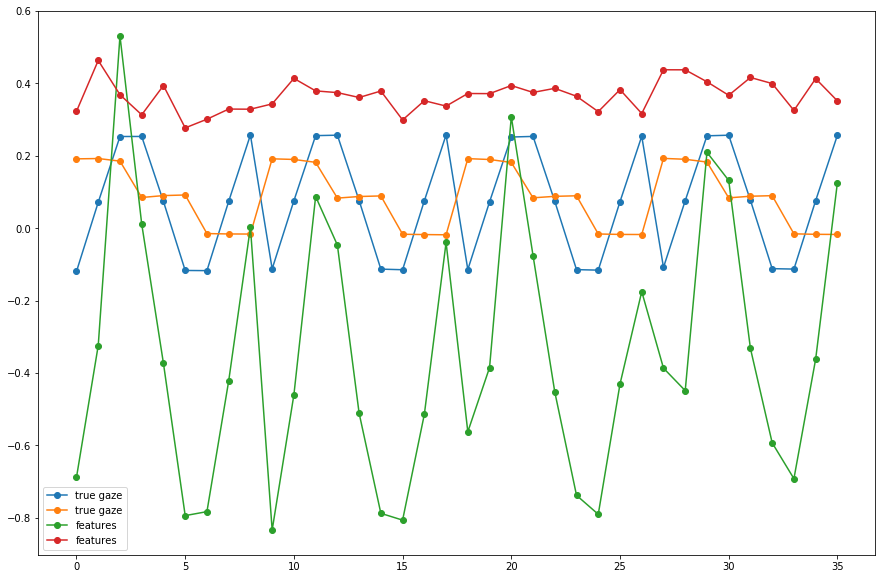

In [152]:
plt.figure(figsize=(15, 10))
plt.plot(vecs2angles(train.eyes.l.true_gazes.reshape(36, 10, 3).mean(axis=1)), 'o-', label='true gaze')
plt.plot(vecs2angles(l_pupil_vector.reshape(36, 10, 3).mean(axis=1)), 'o-', label='features')
plt.legend()

## Train model

In [220]:
from sklearn.preprocessing import SV

In [274]:
poly_features = 2

pipe_left = make_pipeline(
    Normalizer(),
    MultiOutputRegressor(SVR(C=1e1, gamma=0.1))
)

pipe_right = make_pipeline(
    Normalizer(),
    MultiOutputRegressor(SVR(C=1e1, gamma=0.1))
)

train_features_r = [
    vecs2angles(r_pupil_vector).reshape(36, 10, 2).mean(axis=1),
    vecs2angles(l_pupil_vector).reshape(36, 10, 2).mean(axis=1),
    train.rotations.reshape(36, 10, 3).mean(axis=1),
]


train_features_l = [
    vecs2angles(l_pupil_vector).reshape(36, 10, 2).mean(axis=1),
    vecs2angles(r_pupil_vector).reshape(36, 10, 2).mean(axis=1),
    train.rotations.reshape(36, 10, 3).mean(axis=1),
]

X_r = np.column_stack(train_features_r)
X_l = np.column_stack(train_features_l)

Y_r = vecs2angles(train.eyes.r.true_gazes.reshape(36, 10, 3).mean(axis=1))
Y_l = vecs2angles(train.eyes.l.true_gazes.reshape(36, 10, 3).mean(axis=1))

split = 27

pipe_left.fit(X_l[:split], Y_l[:split])
pipe_right.fit(X_r[:split], Y_r[:split])

print(np.rad2deg(np.abs(pipe_left.predict(X_l[split:]) - Y_l[split:])).mean(axis=0))
print(np.rad2deg(np.abs(pipe_right.predict(X_r[split:]) - Y_r[split:])).mean(axis=0))

[3.53634992 3.78671994]
[3.54476037 3.79493901]


## Test model

In [229]:
test_features_r = [
    vecs2angles(r_pupil_vector),
    train.rotations,
]


test_features_l = [
    vecs2angles(l_pupil_vector),
    train.rotations,
]

X_test_r = smooth(np.column_stack(test_features_r), 5)
X_test_l = smooth(np.column_stack(test_features_l), 5)

train.eyes.r.gazes = angles2vecs(pipe_right.predict(np.tile(X_r, (1, 10)).reshape(360, -1)))
train.eyes.l.gazes = angles2vecs(pipe_left.predict(np.tile(X_l, (1, 10)).reshape(360, -1)))

In [230]:
train.create_video(360,
                   verbose=True,
                   victor_gaze=False,
                   face_gaze=False,
                   true_gaze=True,
                   pred_gaze=True,
                   output_path='output_train_raw.avi')

100%|██████████| 360/360 [01:15<00:00,  4.74it/s]


In [120]:
l_pupil_vertical = (test.eyes.l.midbot_vector + test.eyes.l.midtop_vector)
l_pupil_horizontal = (test.eyes.l.inner_vector + test.eyes.l.outer_vector)

r_pupil_vertical = (test.eyes.r.midbot_vector + test.eyes.r.midtop_vector)
r_pupil_horizontal = (test.eyes.r.inner_vector + test.eyes.r.outer_vector)

# l_pupil_vertical = l_pupil_vertical / np.linalg.norm(l_pupil_vertical, axis=1, keepdims=True)
# l_pupil_horizontal = l_pupil_horizontal / np.linalg.norm(l_pupil_horizontal, axis=1, keepdims=True)

l_pupil_vector = l_pupil_vertical + l_pupil_horizontal
r_pupil_vector = r_pupil_vertical + r_pupil_horizontal

l_pupil_vector = l_pupil_vector / np.linalg.norm(l_pupil_vector, axis=1, keepdims=True)
r_pupil_vector = r_pupil_vector / np.linalg.norm(r_pupil_vector, axis=1, keepdims=True)

features_r_test = [
        l_pupil_vector,
        r_pupil_vector,
    test.rotations,
]

features_l_test = [
            l_pupil_vector,
        r_pupil_vector,
    test.rotations,
]

X_r_test = smooth(np.column_stack(features_r_test), 3)
X_l_test = smooth(np.column_stack(features_l_test), 3)

In [188]:
test_rotations = smooth(test.rotations, 3)


test.eyes.r.gazes = angles2vecs(pipe_right.predict(X_r_test))
test.eyes.l.gazes = angles2vecs(pipe_left.predict(X_l_test))

# test.eyes.r.gazes = vectors_to(test.eyes.r.gazes, test_rotations, to='origin')
# test.eyes.l.gazes = vectors_to(test.eyes.l.gazes, test_rotations, to='origin')

SyntaxError: invalid syntax (<ipython-input-188-e1f3f36341b1>, line 3)

In [58]:
trace = create_trace_3d((train.eyes.l.inner_vector / train.eyes.l.outer_vector), **marker_style)

layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0), width=1000, height=1000)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig, filename='simple-3d-scatter')

In [13]:
test.eyes.l.v_gazes = test.eyes.l.v_gazes.reshape(-1, 3)
test.eyes.r.v_gazes = test.eyes.r.v_gazes.reshape(-1, 3)

In [14]:
test.eyes.r.v_gazes = smooth(test.eyes.r.v_gazes, 3)
test.eyes.l.v_gazes = smooth(test.eyes.l.v_gazes, 3)

In [15]:
train.eyes.l.v_gazes = train.eyes.l.v_gazes.reshape(-1, 3)
train.eyes.r.v_gazes = train.eyes.r.v_gazes.reshape(-1, 3)

# train.eyes.r.v_gazes = vectors_to(train.eyes.r.v_gazes, rotations, to='origin')
# train.eyes.l.v_gazes = vectors_to(train.eyes.l.v_gazes, rotations, to='origin')

train.eyes.r.v_gazes = smooth(train.eyes.r.v_gazes, 3)
train.eyes.l.v_gazes = smooth(train.eyes.l.v_gazes, 3)

In [26]:
train.eyes.r.gazes = train.eyes.r.inner_vector + train.eyes.r.outer_vector
train.eyes.l.gazes = train.eyes.l.inner_vector + train.eyes.l.outer_vector

In [122]:
test.create_video(300,
                  victor_gaze=True,
                  face_gaze=False,
                  true_gaze=False,
                  pred_gaze=True,
                  verbose=True,
                  output_path='output_test_1.avi')

100%|██████████| 300/300 [01:01<00:00,  4.91it/s]


In [ ]:
i = 23

point_traces = [
    create_trace_3d(data.reshape(-1, 3), **marker_style) 
    for data in [translations[i],
#                  markers,
                 np.stack((left_pupil_centers[i], right_pupil_centers[i])),
                 face_points_array[i]]
]

line_left_traces = [
    create_trace_3d(np.stack((left_pupil_centers[i], left_pupil_centers[i]+left_gazes_true[i]/10)), **line_style)
]
line_right_traces = [
    create_trace_3d(np.stack((right_pupil_centers[i], right_pupil_centers[i]+right_gazes_true[i]/10)), **line_style)
]

line_pred_left_traces = [
    create_trace_3d(np.stack((left_pupil_centers[i], left_pupil_centers[i]+left_gazes_pred[i]/10)), **line_style)
]
line_pred_right_traces = [
    create_trace_3d(np.stack((right_pupil_centers[i], right_pupil_centers[i]+right_gazes_pred[i]/10)), **line_style)
]

layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0), width=1000, height=1000)

fig = go.Figure(data=point_traces+line_left_traces+line_right_traces+line_pred_left_traces+line_pred_right_traces,
                layout=layout)
iplot(fig, filename='simple-3d-scatter')

[[153.78511375 104.44225223]
 [390.96767959 104.80564946]
 [599.93897742 104.85091871]
 [604.2017778  227.01410877]
 [398.99984171 234.5367799 ]
 [167.34151633 243.00166754]
 [180.09835292 375.72450418]
 [406.6984885  359.37375538]
 [608.06163273 344.88471418]]


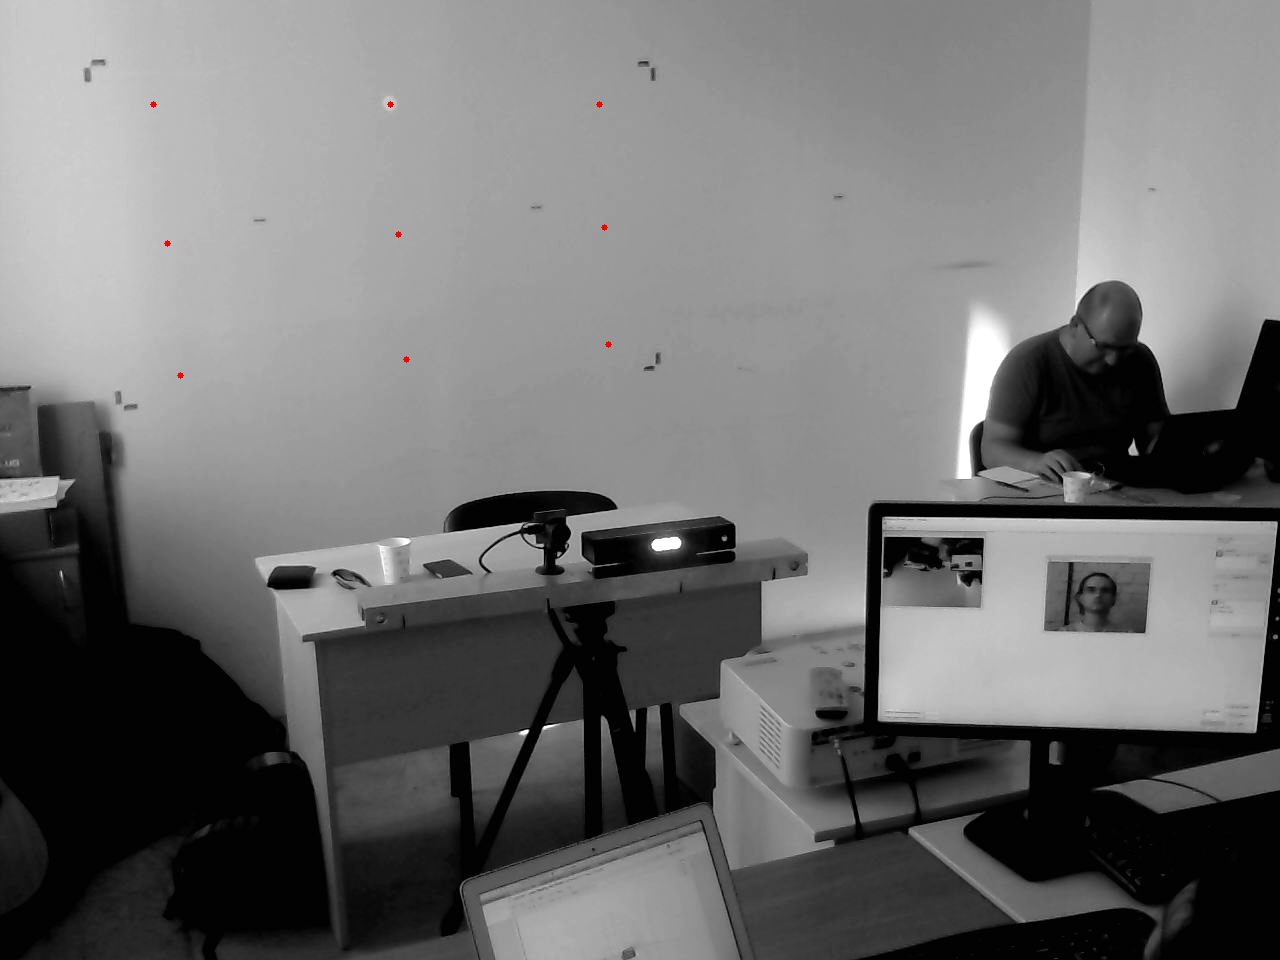

In [63]:
img = np.copy(train_sess.read_snapshot(100).WebCamera[::-1, ::, :])

calibration_points_3d = test_markers

# get point in 2d
calibration_points_2d = WebCamera.project_vectors(calibration_points_3d)
print(calibration_points_2d)

for point in calibration_points_2d:
    cv2.circle(img, tuple(point.astype(int)), 3, (255, 0, 0), -1)
    
# cv2.circle(img, tuple(calibration_points_2d[-1].astype(int)), 3, (0, 255, 0), -1)
Image.fromarray(img)

In [196]:
# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output_test.avi',fourcc, 10.0, (1280, 960))

for i, snapshot in enumerate(test_sess.snapshots_iterate(240, 240+8*10, verbose=True)):
    
    # calculate intersection point
#     point_gaze_true = plane_line_intersection(np.stack((right_gazes_true[i]+right_pupil_centers[i], right_pupil_centers[i])),
#                         test_markers[[0, 2, -1], :])
    point_gaze_pred = plane_line_intersection(np.stack((left_gazes_pred[i]+left_pupil_centers[i], left_pupil_centers[i])),
                        test_markers[[0, 2, -1], :])
    
    # get webcam image
    webcam_img = np.copy(snapshot.WebCamera[::-1,::,:])
    
    # get basler image
    ir_img = np.copy(snapshot.InfraredCamera[:, ::-1, ::])
    
    pupil_2d = InfraredCamera.project_vectors(left_pupil_centers[i].reshape(1, 3))
    
    cv2.circle(ir_img, tuple(pupil_2d[0].astype(int)), 3, (255, 0, 0), -1)
    
    points_to_project = np.vstack((point_gaze_true, point_gaze_pred))
    
    projected_points_to_web = WebCamera.project_vectors(points_to_project)
    
#     gaze_line_true = np.vstack((left_pupil_centers[i], left_gazes_true[i]/10+left_pupil_centers[i]))
    gaze_line_pred = np.vstack((left_pupil_centers[i], left_gazes_pred[i]/10+left_pupil_centers[i]))
    
#     projected_points_to_ir_true = InfraredCamera.project_vectors(gaze_line_true)
    projected_points_to_ir_pred = InfraredCamera.project_vectors(gaze_line_pred)
    
#     pt1_t, pt2_t = projected_points_to_ir_true
    pt1_p, pt2_p = projected_points_to_ir_pred
#     cv2.line(ir_img, tuple(pt1_t.astype(int)), tuple(pt2_t.astype(int)), (255, 0, 0), 3)
    cv2.line(ir_img, tuple(pt1_p.astype(int)), tuple(pt2_p.astype(int)), (0, 0, 255), 3)
    
    ir_resized = cv2.resize(ir_img, (0,0), fx=0.4, fy=0.4)
    
#     cv2.circle(webcam_img, tuple(projected_points_to_web[0].astype(int)), 3, (255, 0, 0), -1)
    cv2.circle(webcam_img, tuple(projected_points_to_web[1].astype(int)), 3, (0, 0, 255), -1)
    
    ir_h, ir_w = ir_resized.shape[:2]
    webcam_img[-ir_h:, 0:ir_w] = ir_resized
    out.write(webcam_img)
    
out.release()
# Image.fromarray(webcam_img)

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:14<00:00,  5.66it/s]
